# Multiple Experiments: ensemble and avg

### Import functions and packages

In [8]:
import sys

sys.path.insert(1, '../')

from Utils import *
from modeling import *

create_dir('data')
create_dir('output')

seed = random.randint(1, 10000)
np.random.seed(seed)
print(seed)

n_shots = 100
p1_avg = []
p1_ens = []

N_runs = 50

The directory data  already exists
The directory output  already exists
7146


In [9]:
y_labels =[[0,1], [1,0]]

In [10]:
for run in np.arange(N_runs):
    # print(run)
    x1 = [np.random.randint(1, 9), np.random.randint(1, 9)]#; x1_train = normalize_custom(x1_train) # y1 = '1'
    x2 = [np.random.randint(1, 9), np.random.randint(1, 9)]#; x2_train = normalize_custom(x2_train) # y2 = '0'
    x3 = [np.random.randint(1, 9), np.random.randint(1, 9)]#; x3_train = normalize_custom(x3_train) # y3 = '1'
    x4 = [np.random.randint(1, 9), np.random.randint(1, 9)]#; x4_train = normalize_custom(x4_train) # y4 = '0'
    
    y1 = y_labels[np.random.randint(0, 2)]
    y2 = y_labels[np.random.randint(0, 2)]
    y3 = y_labels[np.random.randint(0, 2)]
    y4 = y_labels[np.random.randint(0, 2)]
    
    Y_data = [y1, y2, y3, y4]  
    X_data = [x1, x2, x3, x4]
    
    x_test = [np.random.randint(-9, 9), np.random.randint(-9, 9)]#; x_test = normalize_custom(x_test)

    X_data, Y_data, x_test = load_data_custom(X_data, Y_data, x_test = x_test)

    qc1 = cos_classifier(X_data[0], x_test, Y_data[0] )
    r1 = exec_simulator(qc1)
    r1 = retrieve_proba(r1)

    qc2 = cos_classifier(X_data[1], x_test, Y_data[1])
    r2 = exec_simulator(qc2)
    r2 = retrieve_proba(r2)

    qc3 = cos_classifier(X_data[2], x_test, Y_data[2])
    r3 = exec_simulator(qc3)
    r3 = retrieve_proba(r3)

    qc4 = cos_classifier(X_data[3], x_test, Y_data[3])
    r4 = exec_simulator(qc4)
    r4 = retrieve_proba(r4)
     
    out = [r1, r2, r3, r4]

    p0 = [p[0] for p in out]
    p1 = [p[1] for p in out]
    
    r_avg = [np.mean(p0), np.mean(p1)]
    # print('AVG:', r_avg)

    
    qc = ensemble_fixed_U(X_data, Y_data, x_test)
    r = exec_simulator(qc, n_shots=n_shots)
    r_ens = retrieve_proba(r)
    # print('Ensemble', r_ens)

    out = [r1, r2, r3, r4, r_avg, r_ens]
    
    p1_avg.append(r_avg[1])
    p1_ens.append(r_ens[1])

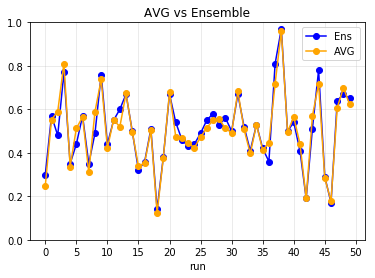

In [12]:
plt.plot(np.arange(N_runs), p1_ens, marker='o', color='blue', label='Ens')
plt.plot(np.arange(N_runs), p1_avg, marker='o', color='orange', label = 'AVG')
plt.title('AVG vs Ensemble')
plt.xlabel('run')
plt.xticks(np.arange(0, N_runs+1, 5))
plt.ylim(0,1)
plt.grid(alpha=.3)
plt.legend()
plt.savefig('output/multi_run_fixed.png', dpi = 300)

In [13]:
ttest_ind(p1_ens, p1_avg)

Ttest_indResult(statistic=0.07177749510704115, pvalue=0.9429252653048444)

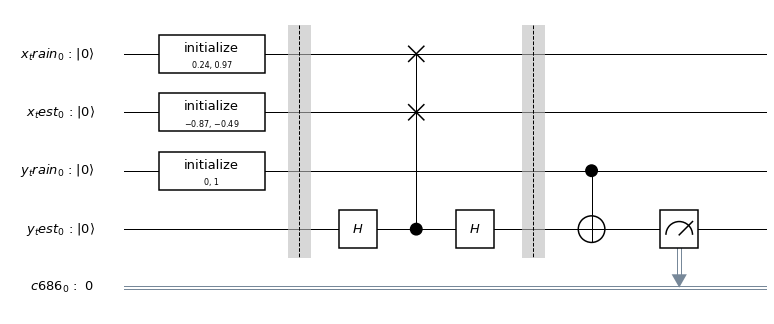

In [14]:
qc1.draw(output='mpl', scale=.9)

In [15]:
qc.draw()